In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
from sklearn.impute import KNNImputer

In [2]:
from matplotlib.patches import Patch
import matplotlib.cm as cm
import matplotlib.pyplot as plt

In [3]:
from sklearn.metrics import silhouette_samples, silhouette_score

In [4]:

'''
Functions to handle mapping values to colors for seaborn clustermap
Author: Stephanie Ting
Stephanie.Ting.3@gmail.com
7/24/2023
Last edited:
7/31/2025
'''
from matplotlib.pyplot import get_cmap
import matplotlib.colors

black = matplotlib.colors.to_rgba("black")
gray = "#DDDDDD"
white = matplotlib.colors.to_rgba("white")
#PAM50 colors
BASAL = "#EB212D"
HER2 = "#F7C1D9" 
LUMINAL_A = "#2F3492"
LUMINAL_B = "#26AFDD"
NORMAL = "#3CB54C"

def _mpl_normalize(s, method, cmap='vlag', **kwargs):

    ''' 
    Internal function that maps continuous variable to 
    matplotlib colormap

    s - pandas Series to be mapped
    cmap - String name of acceptable matplotlib colormap
    method - Normalization function for normalizing data to [0,1] scale
    **kwargs - args for normalization function

    Returns pandas Series object
    '''

    # Make sure dtype is numeric
    s=s.astype(float)

    # Create mapper using desired method and colormap
    norm = method(**kwargs)
    mapper = cm.ScalarMappable(norm=norm, cmap=get_cmap(cmap))

    return((s.map(lambda x: mapper.to_rgba(x)),))

def _map_categorical_colors(s, values, dtype = 'categorical', custom_colors = None):
    ''' 
    Internal function that maps a categorical or binary variable to 
    sns color palettes.

    s - pandas Series to be mapped
    values - values in pandas Series
    dtype - 'categorical', 'pam50', or 'binary' - determines what color 
                            color palette will be used

    Returns pandas Series object
    '''
    
    if custom_colors == None:
        if dtype == 'categorical':
            colorscheme = [i+(1,) for i in sns.color_palette("bright")+sns.color_palette("pastel")+sns.color_palette("dark")]
    
        elif dtype == 'binary':
            if len(values) == 3:
                colorscheme = [white, gray, black]
            elif len(values) <= 2:

                colorscheme = [gray, black]
            else:
                raise AssertionError(
                        "binary data type must have 2 values"
                        )   
        elif dtype == 'pam50':
            colorscheme = [BASAL, HER2, LUMINAL_A, LUMINAL_B, NORMAL]
        sorted_values = list(values)
        color_dict=dict(zip(sorted_values, colorscheme))
    else:
        color_dict = custom_colors
    #Return color key as well for referencing
    return((s.map(color_dict), color_dict))
def make_color_annotations(ds, datatype, normalization_method = "linear", normalization_center = 0, color_value_order = None, custom_colors = None):
    ''' 
    Makes a color annotation pandas Series or DataFrame mapping value to rgba value 
    (intended for seaborn.clustermap)
    ds - pandas DataFrame object with each category of features to be mapped as
        columns and the features as rows
    datatype - iterable containing "continuous", "categorical", "pam50", and/or "binary"
    color_value_order - dict of lists of values for order in which values should be assigned to colors. 
                        if None, values will be sorted ascending numerically or alphabetically
                        
                        for categorical colors the colors are in order of palette "bright"
                        followed by "pastel"
                        
                        for binary colors the colors are in order of black, gray, white 
    normalization_center - numeric value or "median" for continuous data type to center normalization on
                           if normalization method = "centered"
                           TODO: allow to take functions
    custom_colors - python dict containing value:colors for custom colors. If None, default colors
    '''
    
    if not len(datatype) == ds.shape[1]:
        raise AssertionError(
                "Datatype should be an iterable with length equivalent to number of columns in ds"
                )   
    
    if not type(ds) == pd.core.frame.DataFrame:
        raise AssertionError(
                "ds should be of type pandas DataFrame"
                )   
    return_series=[]
    return_keys=[]
    for column, dtype in zip(ds.columns, datatype):
        group=ds.loc[:, column]
        if not dtype in ["continuous", "categorical", "pam50", "binary"]:
            raise AssertionError(
                    "datatype must be \"continuous\", \"categorical\", \"pam50\", or \"binary\""
                    )   
    
        if dtype == "continuous":
            group=group.astype(float)
            if normalization_method == "linear":
                return_series.append(_mpl_normalize(group, matplotlib.colors.Normalize,
                                                    vmin=group.quantile(0.25),
                                                    vmax=group.quantile(0.75))[0])
                return_keys.append({"0.25":group.quantile(0.25), "0.75": group.quantile(0.75)})
            elif normalization_method == "centered":
                if normalization_center == "median":
                    normalization_center = np.median(group.values)
                return_series.append(_mpl_normalize(group, matplotlib.colors.CenteredNorm,
                                                    vcenter = normalization_center
                                                    )[0])
                return_keys.append(None)
            else:
                raise AssertionError(
                        "method must be \"linear\" or \"centered\""

            )    
        else:
            #This is to control the order that values are assigned to colors
            #If an order is preferred
            if color_value_order == None:
                value_order = [str(i) for i in set(group.values)]
                value_order.sort()

            elif column in color_value_order:
                if type(color_value_order[column]) == list and  len(color_value_order[column]) == len(set(group.values)):
                    value_order = color_value_order[column]
                else:
                    raise AssertionError(
                            "color_value_order must be a dict with column names as keys and list of values to map as values"
                            )   
    
            cat_colors = _map_categorical_colors(group.astype(str), value_order, dtype, custom_colors)
            return_series.append(cat_colors[0])
            return_keys.append(cat_colors[1])
    
    return_df=pd.DataFrame(return_series)
    return((return_df,dict(zip(return_df.index, return_keys))))
    
    

In [5]:
ann = pd.read_csv("../data/source_data/consensus_peaks.15812.annotation.gencode_V36.bed", sep='\t', header=None)

In [6]:
sample_barcodes = pd.read_csv('../data/source_data/TCGA.m6A.sample_barcodes.Synapse.11302022.txt', sep='\t')

sample_barcodes.drop_duplicates(subset=sample_barcodes.columns, inplace=True)

sample_barcodes_ip = sample_barcodes.set_index("IP")

In [7]:
replicates = ['TCGA-A2-A04W-01A-21R-A933-53',
 'TCGA-A2-A0CP-01A-21R-A933-53',
 'TCGA-A7-A0CH-01A-11R-A933-53',
 'TCGA-A8-A079-01A-11R-A933-53',
 'TCGA-C5-A2LX-01A-21R-A933-53',
 'TCGA-FA-A6HO-01A-21R-A933-53',
 'TCGA-FF-A7CX-01A-21R-A933-53',
 'TCGA-ZB-A96D-01A-21R-A933-53']

In [8]:
gene_matrix=pd.read_csv('../data/source_data/m6a_matrix.15812.normalized.csv', index_col=0)

print("Gene x sample matrix size: {}".format(gene_matrix.shape))

print("Dropping replicates...")
gene_matrix.drop(columns = replicates, inplace = True)

print("Dropping genes with all 0s...")
gene_matrix=gene_matrix.loc[(gene_matrix!=0).any(axis=1)]

print("Gene x sample matrix size: {}".format(gene_matrix.shape))

#Filter for peaks with 70% data present

data = gene_matrix
print("Original matrix: {}".format(data.shape))
print("Dropping rows with more than 30% missing values.")
na_thres = data.shape[1]*0.7
data.dropna(thresh=na_thres, inplace=True)
      
print("New shape: {}".format(data.shape))

#Impute missing data (KNN imputer)
print("Imputing missing values.")
imputer = KNNImputer()
imputed_data=pd.DataFrame(imputer.fit_transform(data.T)).T
imputed_data.columns = data.columns
imputed_data.index = data.index

#Filter by most variable most expressed
print("Filtering by std")
std=imputed_data.std(axis=1).to_frame()
top_std=std.quantile(q=0.75).values[0]

mean=imputed_data.mean(axis=1).to_frame()
top_mean=mean.quantile(q=0.75).values[0]

filtered_genes=std.loc[std[0]>top_std].index
filtered_mean=mean.loc[filtered_genes]

imputed_data_filtered=imputed_data.loc[filtered_mean.index]
imputed_data_filtered.shape

Gene x sample matrix size: (15812, 234)
Dropping replicates...
Dropping genes with all 0s...
Gene x sample matrix size: (15812, 226)
Original matrix: (15812, 226)
Dropping rows with more than 30% missing values.
New shape: (14207, 226)
Imputing missing values.
Filtering by std


(3552, 226)

In [9]:
peak2gene = {}
gene2peak = {}
gene2peak_in_data = {}
for entry in ann.index:
    peak_name = ann.loc[entry][3]
    extra = ann.loc[entry][14].split(';')
    gene_name = None
    for i in extra:
        phrase = i.split(" ")
        if "gene_name" in phrase:
            gene_name = phrase[2].strip("\"\'")
    if gene_name == None or gene_name == '':
        print(entry)
        continue
    peak2gene[peak_name] = gene_name
    if not gene_name in gene2peak:
        gene2peak[gene_name] = [peak_name]
    else:
        gene2peak[gene_name].append(peak_name)
    if peak_name in imputed_data.index:
        if not gene_name in gene2peak_in_data:
            gene2peak_in_data[gene_name] = [peak_name]
        else:
            gene2peak_in_data[gene_name].append(peak_name)

In [10]:
exp = pd.read_csv('../data/processed_data/deseq2_normalized_selected_tcga_expression.csv', index_col=0)

print("Dropping genes with all 0s for whole dataset...")
exp=exp.loc[(exp!=0).any(axis=1)]
print("Gene x sample matrix size: {}".format(exp.shape))

print("Taking average of duplicate genes...")
exp=exp.groupby(exp.index).mean()
exp=exp.groupby(exp.columns, axis = 1).mean()

exp.columns = [i.replace(".", "-") for i in exp.columns]

exp2m6a = {}
m6a2exp = {}
exp_samples = {"-".join(i.split("-")[:4]):i for i in exp.columns}


for sample in imputed_data_filtered.columns:
    patient = "-".join(i for i in sample.split("-")[:4])
    exp_sample = exp_samples[patient]
    exp2m6a[exp_sample] = sample
    m6a2exp[sample] = exp_sample



exp = exp.loc[:, [m6a2exp[i] for i in imputed_data_filtered.columns]]

exp = exp.groupby(exp.columns, axis=1).mean()

print("Shift by 0.01...")
exp_shifted=exp.applymap(lambda x: x+0.01)

print("Log2 transforming...")
log_exp=np.log2(exp_shifted)

print("Median centering across samples...")
median = log_exp.median(axis=1)
exp_centered=log_exp.apply(lambda x: x-x.median(), axis=1)

print("Dropping rows with infs and nans...")
exp_centered.replace([np.inf, -np.inf], np.nan, inplace=True)
exp_centered.dropna(how='any', inplace=True)
print("Filtered matrix size: {}".format(exp_centered.shape))

Dropping genes with all 0s for whole dataset...
Gene x sample matrix size: (56638, 248)
Taking average of duplicate genes...


/datastore/scratch/users/sting/ipykernel_3486233/3958636843.py:9: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  exp=exp.groupby(exp.columns, axis = 1).mean()
/datastore/scratch/users/sting/ipykernel_3486233/3958636843.py:28: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  exp = exp.groupby(exp.columns, axis=1).mean()


Shift by 0.01...


/datastore/scratch/users/sting/ipykernel_3486233/3958636843.py:31: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  exp_shifted=exp.applymap(lambda x: x+0.01)


Log2 transforming...
Median centering across samples...
Dropping rows with infs and nans...
Filtered matrix size: (56638, 226)


methylated_genes = [peak2gene[i] for i in imputed_data_filtered.index]
unique_methylated_genes = list(set(methylated_genes))
pd.Series(methylated_genes).value_counts()

len(unique_methylated_genes)

In [11]:
imputed_data_filtered.to_csv("../data/processed_data/m6a_for_ccp_top25stdmean_wbreast.csv")
imputed_data.to_csv("../data/processed_data/m6a_imputed_data_unfiltered.csv")

In [12]:
k3 = pd.read_csv("../results/ccp_m6a_wbreast/wbreast_labels3.csv", index_col=0)
k3.columns = ["3"]
k4 = pd.read_csv("../results/ccp_m6a_wbreast/wbreast_labels4.csv", index_col=0)
k4.columns = ["4"]
k5 = pd.read_csv("../results/ccp_m6a_wbreast/wbreast_labels5.csv", index_col=0)
k5.columns = ["5"]

k6 = pd.read_csv("../results/ccp_m6a_wbreast/wbreast_labels6.csv", index_col=0)
k6.columns = ["6"]

In [13]:
#Reformat data for sigclust
imputed_data_filtered_k5 = imputed_data_filtered.T
imputed_data_filtered_k5.index = [i.replace("-", ".") for i in imputed_data_filtered_k5.index]
imputed_data_filtered_k5["k5"] = k5
imputed_data_filtered_k5 = imputed_data_filtered_k5.T
print(imputed_data_filtered_k5.shape)
imputed_data_filtered_k5 = imputed_data_filtered_k5.iloc[range(imputed_data_filtered_k5.shape[0]-1, -1, -1)]

(3553, 226)


In [14]:
imputed_data_filtered_k5.to_csv("../data/processed_data/m6a_k5ccp_wbreast_for_sigclust.csv")

In [15]:
ks = pd.DataFrame([k3.squeeze(), k4.squeeze(), k5.squeeze(), k6.squeeze()])
ks.columns = [i.replace(".", "-") for i in ks.columns]

In [16]:
ks.index = [int(i) for i in ks.index]

In [17]:
label_colors, label_colors_keys = make_color_annotations(ks.T, ["categorical"]*4)

In [18]:
pancan_colors = pd.read_excel("../data/source_data/pancan33.colors.xlsx", engine = "openpyxl", index_col=0, header = None)
pancan_colors = pancan_colors[1].to_dict()

In [19]:
pancan_colors

{'ACC': '#CC3300',
 'BLCA': '#A6CEE3',
 'BRCA': '#1F78B4',
 'CESC': '#FFCCFF',
 'CHOL': '#66FF99',
 'COAD': '#B2DF8A',
 'DLBC': '#006666',
 'ESCA': '#CCCC00',
 'GBM': '#33A02C',
 'HNSC': '#FB9A99',
 'KICH': '#660000',
 'KIRC': '#E31A1C',
 'KIRP': '#FF0033',
 'LAML': '#FDBF6F',
 'LGG': '#333333',
 'LIHC': '#99CCCC',
 'LUAD': '#FF7F00',
 'LUSC': '#CAB2D6',
 'MESO': '#CC6699',
 'OV': '#6A3D9A',
 'PAAD': '#003300',
 'PCPG': '#3300CC',
 'PRAD': '#0000CC',
 'READ': '#FFFF99',
 'SARC': '#FF33CC',
 'SKCM': '#000000',
 'STAD': '#FFCC00',
 'TGCT': '#3399FF',
 'THCA': '#666600',
 'THYM': '#CC9966',
 'UCEC': '#B15928',
 'UCS': '#9900FF',
 'UVM': '#999999'}

In [20]:
cancer_type_colors, cancer_type_keys = make_color_annotations(sample_barcodes_ip.loc[:, "Cancer_type_abbv"].to_frame(), ["categorical"], custom_colors = pancan_colors)

In [21]:
label_colors = label_colors.T
label_colors["Cancer Type"] = cancer_type_colors.squeeze()
label_colors = label_colors.T

In [22]:
order_df = sample_barcodes_ip.loc[:, "Cancer_type_abbv"].to_frame().copy()
order_df["cluster"] = ks.T[5].copy()

In [23]:
order_df.dropna(inplace = True)
order = order_df.sort_values(by = ["cluster", "Cancer_type_abbv"]).index

In [24]:
design4limma = pd.get_dummies(k5["5"]).astype(int)

design4limma.to_csv("../data/processed_data/cluster_design_for_limma.csv")

In [25]:
design4limma

,1,2,3,4,5
TCGA.05.4384.01A.21R.2190.53,1,0,0,0,0
TCGA.06.5859.01A.21R.1899.53,0,1,0,0,0
TCGA.14.0871.01A.21R.1898.53,0,0,1,0,0
TCGA.18.5595.01A.21R.2194.53,0,0,0,1,0
TCGA.2G.AAF4.01A.21R.A45P.53,1,0,0,0,0
...,...,...,...,...,...
TCGA.ZB.A96R.01A.21R.A45S.53,0,0,1,0,0
TCGA.ZC.AAAF.01A.21R.A45S.53,0,0,1,0,0
TCGA.ZF.A9RM.01A.21R.A459.53,1,0,0,0,0
TCGA.ZJ.AAXB.01A.21R.A40J.53,0,0,1,0,0


In [26]:
g1 = pd.read_csv("../results/cluster_limma/1vsall.csv", index_col = 0)
g2 = pd.read_csv("../results/cluster_limma/2vsall.csv", index_col = 0)
g3 = pd.read_csv("../results/cluster_limma/3vsall.csv", index_col = 0)
g4 = pd.read_csv("../results/cluster_limma/4vsall.csv", index_col = 0)
g5 = pd.read_csv("../results/cluster_limma/5vsall.csv", index_col = 0)

In [27]:
de = {
    "g1":g1,
    "g2":g2,
    "g3":g3,
    "g4":g4,
    "g5":g5
}

In [28]:
g3

,logFC,AveExpr,t,P.Value,adj.P.Val,B
consensus_peak-chr1_16250696_16250897_-,-2.855612,0.050667,-5.622347,2.983156e-08,0.000313,8.487663
consensus_peak-chr2_17784003_17784204_+,-2.893908,0.095035,-5.523654,5.102444e-08,0.000313,7.995830
consensus_peak-chr11_72293379_72293580_-,-2.792200,0.087948,-5.475401,6.614300e-08,0.000313,7.758187
consensus_peak-chrX_152869055_152869256_+,-2.775319,0.141852,-5.363578,1.198043e-07,0.000426,7.214624
consensus_peak-chr22_24585717_24585918_-,-2.608001,0.037320,-5.177240,3.150581e-07,0.000895,6.331232
...,...,...,...,...,...,...
consensus_peak-chr16_1445929_1446130_-,-1.481616,-0.091326,-2.929855,3.530249e-03,0.049972,-2.016183
consensus_peak-chr6_32972687_32972888_+,1.514009,-0.087097,2.929850,3.530295e-03,0.049972,-2.016194
consensus_peak-chr22_28107400_28107601_-,1.539622,0.146869,2.929821,3.530619e-03,0.049972,-2.016273
consensus_peak-chr16_4852907_4853108_+,1.521004,0.005499,2.929578,3.533346e-03,0.049972,-2.016939


In [30]:
diff_peak_set = set()
diff_peak_dict = {}
for i in de:
    diff_peak_set = diff_peak_set.union(set(de[i].index))
    for j in set(de[i].index):
        diff_peak_dict[j] = i

groups_ge = pd.Series(diff_peak_dict, name = "group").to_frame()

#groups_ge.index = [peak2gene[i] for i in groups_ge.index]

groups_ge = groups_ge.groupby(groups_ge.index).first()

groups_ge_colors, _ = make_color_annotations(groups_ge, ["categorical"])

len(diff_peak_set)

2460

In [31]:
diff_peaks = list(diff_peak_set)

imputed_data_genes = imputed_data.copy()
imputed_data_genes.index = [peak2gene[i] for i in imputed_data_genes.index]

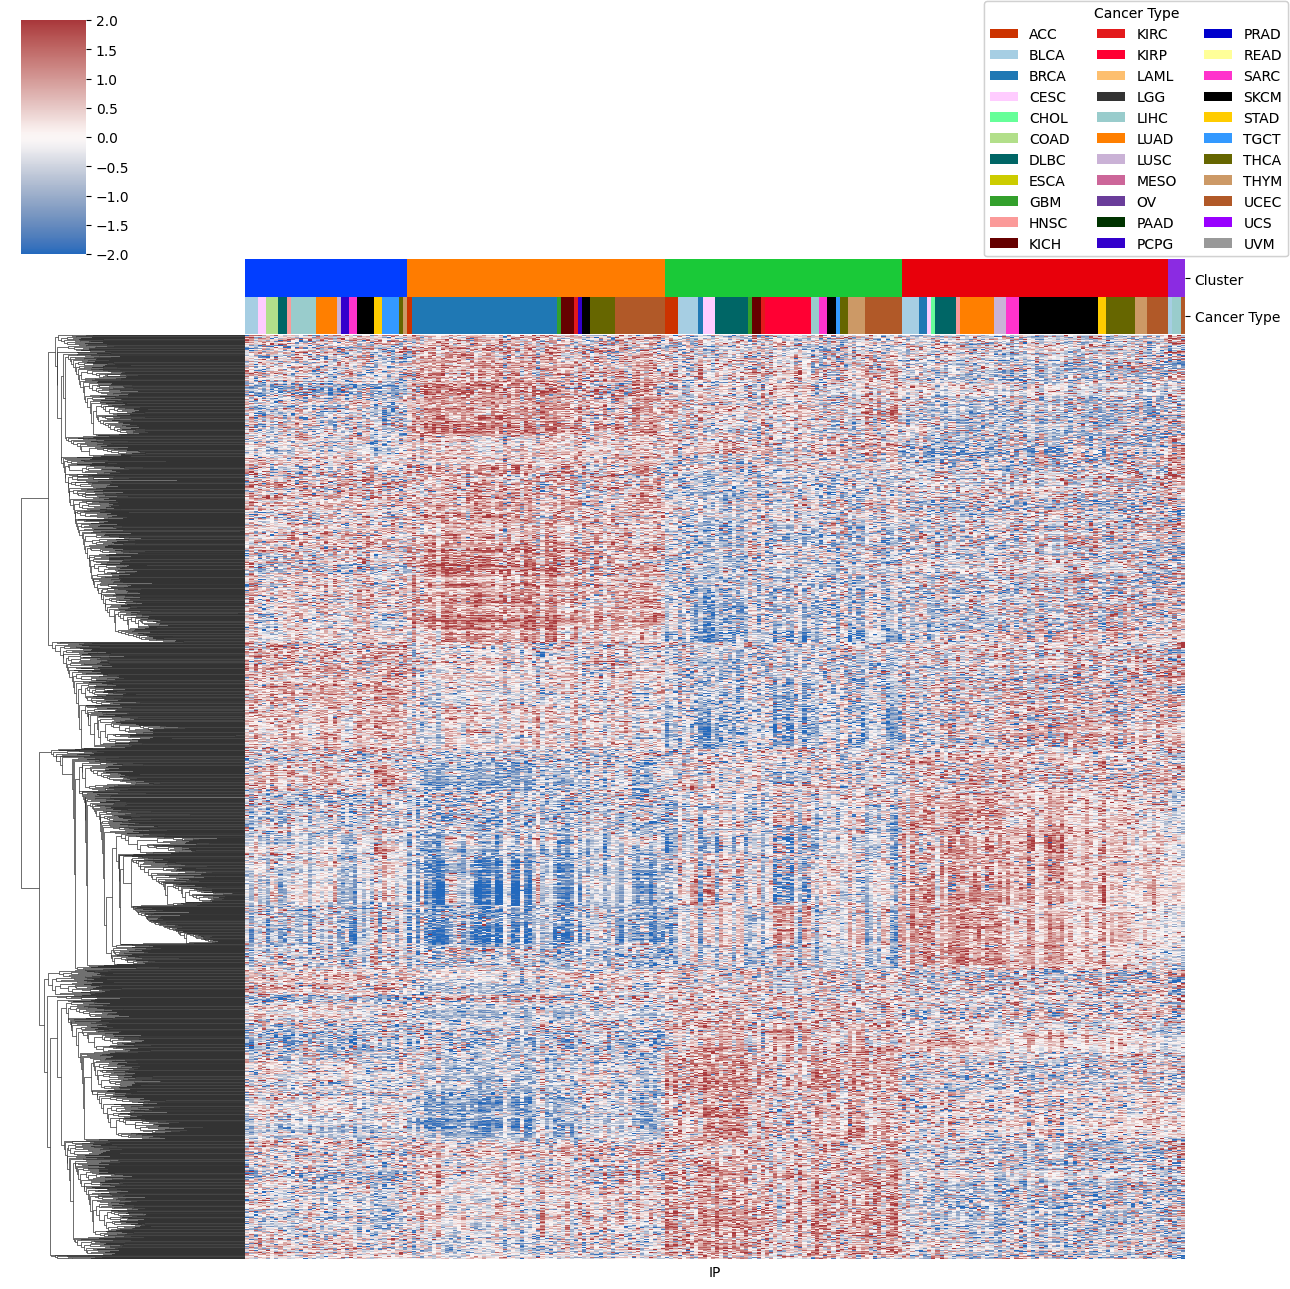

In [32]:
key_dict=cancer_type_keys['Cancer_type_abbv']
handles = [Patch(facecolor=key_dict[name]) for name in key_dict]

label5 = label_colors.loc[[5, "Cancer Type"]].T
label5.columns = ["Cluster", "Cancer Type"]
cluster = sns.clustermap(imputed_data.loc[diff_peaks, order], col_colors=label5, 
                         cmap = "vlag", vmin = -2, vmax = 2, 
                         yticklabels = False, xticklabels = False, figsize = (13, 13),metric = "correlation", col_cluster = False)

legend=plt.legend(handles, key_dict, title="Cancer Type", ncol=3,
          bbox_to_anchor=(1, 1), bbox_transform=plt.gcf().transFigure, loc='upper right')
plt.gca().add_artist(legend)
plt.savefig("../results/Fig2_heatmap_with_diffexp_peaks.pdf", dpi = 300)

In [34]:
exp_label_colors = label_colors.copy()
exp_label_colors.columns = [m6a2exp[i] for i in exp_label_colors.columns]
exp_label_colors = exp_label_colors.groupby(exp_label_colors.columns, axis = 1).min()

/datastore/scratch/users/sting/ipykernel_3486233/1993234667.py:3: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  exp_label_colors = exp_label_colors.groupby(exp_label_colors.columns, axis = 1).min()


In [36]:
counts = k5.copy()

counts.index = [i.replace(".", "-") for i in counts.index]
counts["Cancer Type"] = sample_barcodes_ip.loc[:, "Cancer_type_abbv"]
table = pd.crosstab(index = counts["Cancer Type"], columns = counts["5"])

In [37]:
ratios = table.div(table.sum(axis = 1), axis = 0)

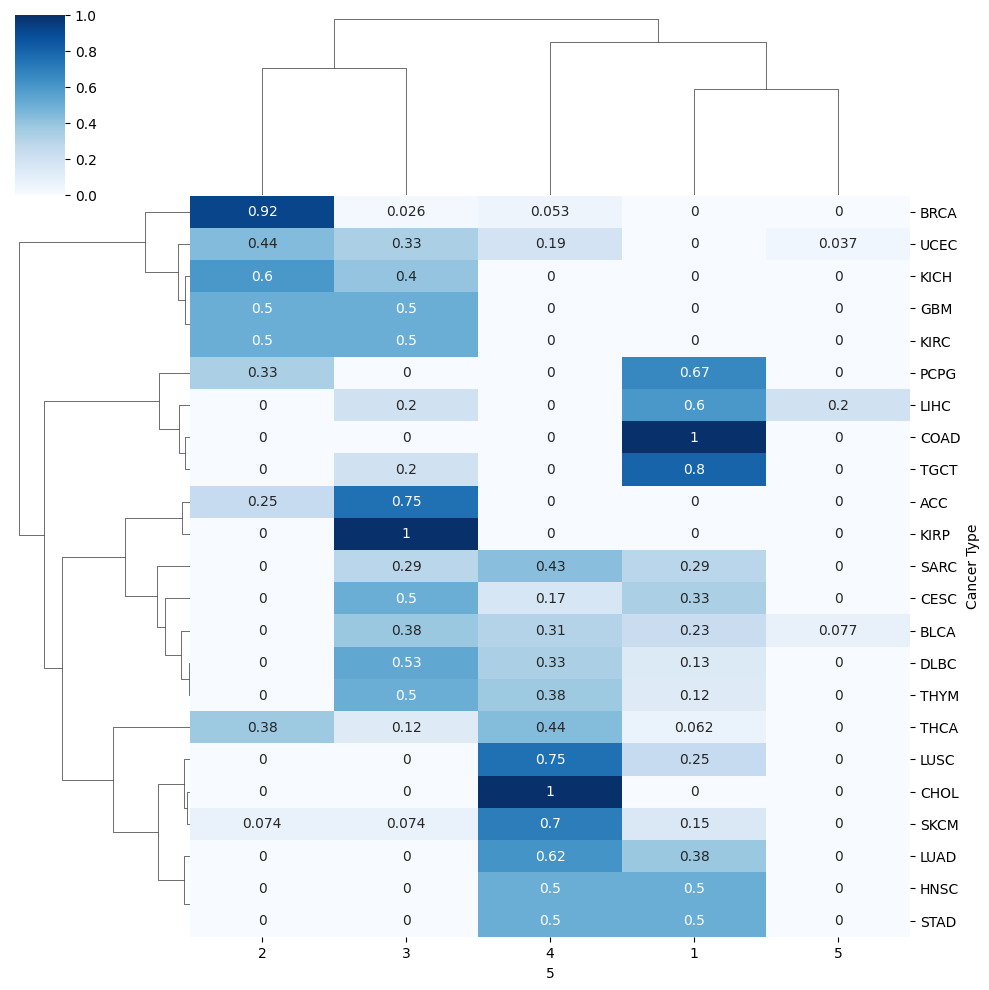

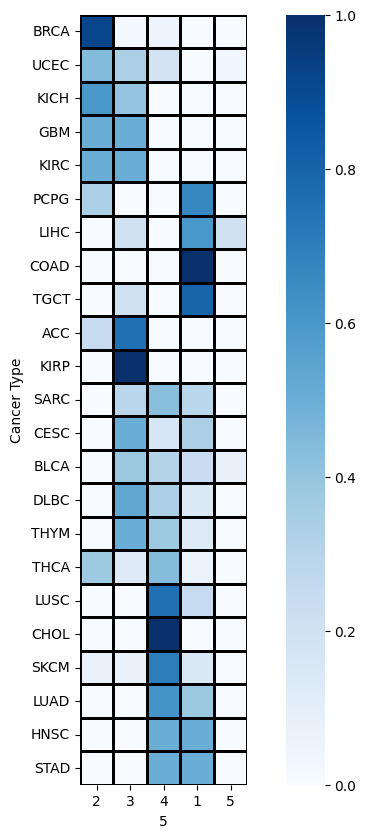

In [38]:
ratios_table = table.div(table.sum(axis = 1), axis = 0)
cluster = sns.clustermap(ratios_table, cmap = "Blues", annot=True, metric = "correlation")
col_ind = cluster.dendrogram_col.reordered_ind
row_ind = cluster.dendrogram_row.reordered_ind
plt.show()
fig, ax = plt.subplots(figsize = (10, 10))
ratios_table_ordered = ratios_table.iloc[row_ind, col_ind]
sns.heatmap(ratios_table_ordered, cmap = "Blues", annot = False, square = True, ax = ax, linewidths = 1, linecolor = "black")
plt.savefig("../results/Fig2_Cancertype_per_cluster.pdf", dpi = 300)
plt.show()

(226, 3552)
(226, 3552)
(226, 3552)
(226, 3552)


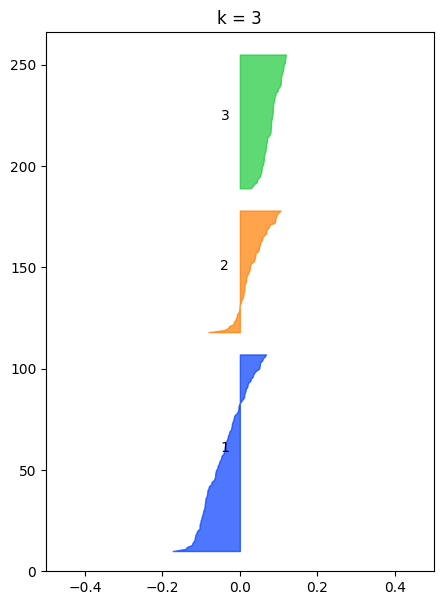

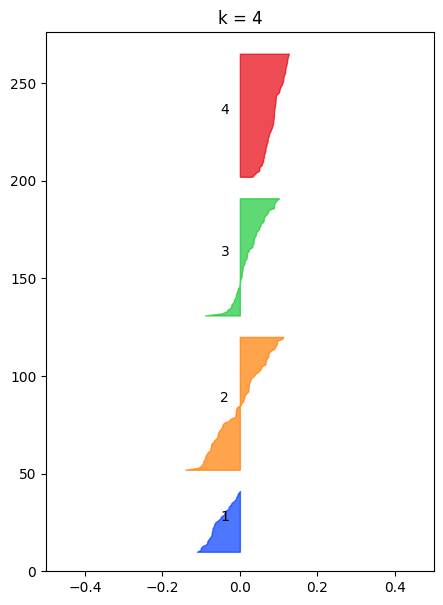

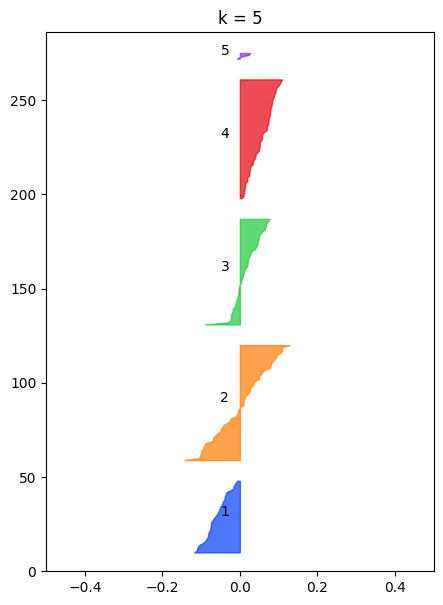

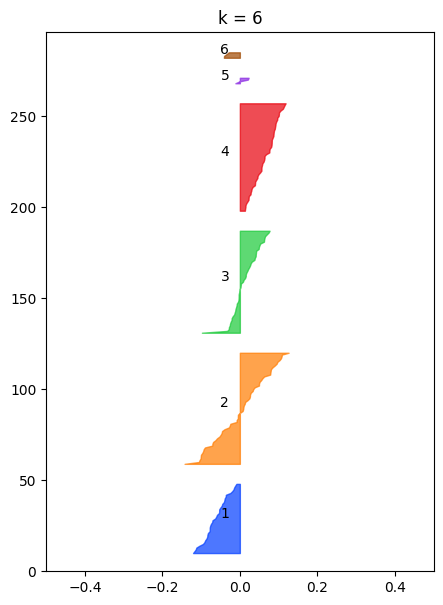

In [39]:
labels = ks.T
n=6
for n in range(3, 7):
    s=set(labels[n].values.flatten())
    n_labels=labels[n].values.flatten()
    samples=labels[n].index
    X=imputed_data_filtered.loc[:,samples].T.values
    print(X.shape)
    silhouette_avg = silhouette_score(X, n_labels)
    
    
    sample_silhouettes=silhouette_samples(X, n_labels)
    y_lower=10
    
    fig, ax=plt.subplots()
    fig.set_size_inches(5, 7)
    
    ax.set_xlim([-.5, .5])
    ax.set_ylim([0, len(X)+(n+1)*10])
    for i in range(1,n+1):
        ith_silhouettes=sample_silhouettes[n_labels==i]
    
        ith_silhouettes.sort()
    
        cluster_size=len(ith_silhouettes)
    
        y_upper=y_lower+cluster_size
    
        color=sns.color_palette("bright")[i-1]
    
        ax.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_silhouettes,
            facecolor=color,
            edgecolor=color,
            alpha=0.7
        )
        
        ax.set_title('k = {}'.format(n))
    
        ax.text(-0.05, y_lower + 0.5*cluster_size, str(i))
    
        y_lower=y_upper+10